<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_AutoDiff_UserCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import scipy as sc
from scipy import special

import jax
import jax.numpy as jnp
import jax.scipy as jsc   

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
#from jax.ops import index, index_update
jax.config.update("jax_enable_x64", True)

from functools import partial


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18


# Le thème: Auto-différentiation appliquée sur des algorithmes
Example de l'algorithme recursif d'extraction de la racine carrée d'un nombre

## version Numpy simple

In [2]:
def sqrt_rec(x):
    val = x
    for i in range(0,10):
        val = (val+x/val)/2.
    return val


## version JAX tout aussi simple: on bannit cependant l'usage de la boucle for

In [3]:
@jit # compilation deco
def jax_sqrt_rec(x):
    
    # struture: val = body(i,val)
    def body(i,val):
        return (val+x/val)/2.

    # struture: val =  loop(i_start, i_end, function, initialisation)
    return jax.lax.fori_loop(0,10,body,x)


## On applique le gradient que l'on vectorize

In [4]:
vgradsqrt = vmap(grad(jax_sqrt_rec))

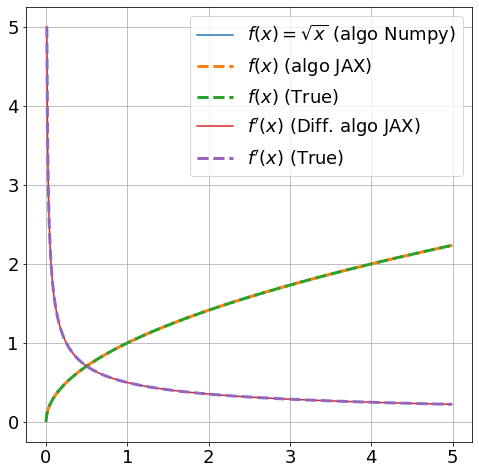

In [5]:
plt.figure(figsize=(8,8))
x = jnp.arange(0,5,0.01)
plt.plot(x, sqrt_rec(x), label=r"$f(x)=\sqrt{x}$ (algo Numpy)")
plt.plot(x, jax_sqrt_rec(x), lw=3,ls='--', label=r"$f(x)$ (algo JAX)")
plt.plot(x, jnp.sqrt(x), lw=3,ls='--', label=r"$f(x)$ (True)")

plt.plot(x, vgradsqrt(x), label=r"$f^\prime(x)$ (Diff. algo JAX)")

#plt.plot(x, vmap(grad(root))(x), label=r"$f^\prime(x)$ (Diff. algo Numpy)")  # Tout a fait possible mais moins Jax-idiom
plt.plot(x, 1/(2*jnp.sqrt(x)), lw=3,ls='--',label=r"$f^\prime(x)$ (True)")
plt.legend()
plt.grid();

In [6]:
# Si vous êtes curieux: jax.make_jaxpr(jax_sqrt_rec)(1.)

# Code d'intégration de Simpson (composite)
$$
\begin{align}
\int_a^b f(x)dx &\approx \frac{b-a}{3n}\sum_{j=1}^{n/2}\left[ f(x_{2j-2} + 4 f(x_{2j-1}) + f(x_{2j}))\right] \\
&= \frac{b-a}{6n} \left[f(x_0)+ 4 \sum_{j=1}^{n/2}f(x_{2j-1}) + 2 \sum_{j=1}^{n/2-1} f(x_{2j}) +f(x_n) \right]
\end{align}
$$

In [7]:
# Version Numpy
def simps(f, a, b, N):
    assert N%2==0, f"use N even but get {N}"
    dx = (b - a) / N
    x = np.linspace(a, b, N + 1)
    y = f(x)
    w = np.ones_like(y)
    w[2:-1:2] = 2.
    w[1::2]   = 4.
    S = dx / 3. * np.einsum("i...,i...",w,y)
    return S


In [8]:
#version JAX
@partial(jit, static_argnums=(0,3))  # f et N ne seront des vecteurs
def jax_simps(f, a,b, N=512):
    assert N%2==0, f"use N even but get {N}"
    #N doit etre paire
    dx = (b - a) / N
    x = jnp.linspace(a, b, N + 1)
    y = f(x)
    w = jnp.ones_like(y)
    w = w.at[2:-1:2].set(2.)     # w est immutable
    w = w.at[1::2].set(4.)
    S = dx / 3. * jnp.einsum('i...,i...',w,y)
    return S


In [9]:
def func(x):
    return x**(1/10) * jnp.exp(-x)


In [10]:
a = 0.
b = a+0.5

In [11]:
simps(func, a, b, N=100)

0.32893074802674666

In [12]:
print(jax_simps(func, a, b, N=100))

0.3289307480267466


In [32]:
print(jax_simps(func, a, b, N=2**10)) #slow convg..

0.3296644440883527


In [15]:
sc.special.gamma(1.+1./10)*(1.-sc.special.gammaincc(1.+1./10,0.5))

0.3296908257616642

nb. jax.scipy implémente un certain nombre de fonctionalités de Scipy mais pas toutes.

In [16]:
# Famille de functions
@jit
def jax_funcN(x):
    return jnp.stack([x**(i/10) * jnp.exp(-x) for i in range(50)],axis=1)

In [17]:
# lots d'intervalles d'integration [a,a+1/2] a:0,0.1,0.2...
ja = jnp.arange(0,20,0.1)
jb = ja+0.5

In [18]:
res = jax_simps(jax_funcN,ja,jb,  N=2**10)

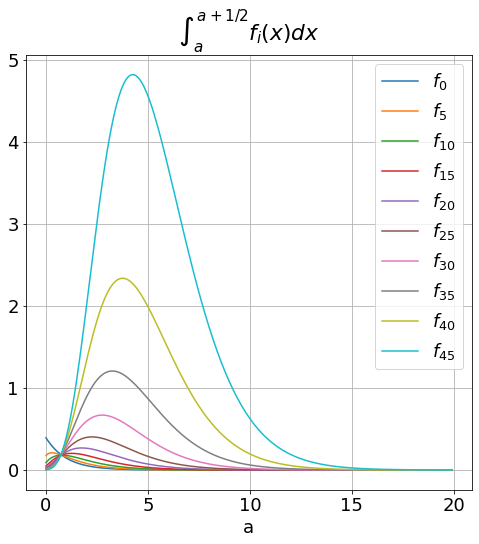

In [19]:
plt.figure(figsize=(8,8))
for i in range(0,50,5):
    plt.plot(ja,res[i,:],label=rf"$f_{{{i}}}$")
plt.xlabel("a")
plt.title(r"$\int_{a}^{a+1/2} f_i(x) dx$")
plt.grid()
plt.legend();

# Vérification que le Gradient de l'integration = la fonction
$$
\frac{d}{dx} \int_a^x f(z) dz = f(x)
$$

In [20]:
f5 = lambda x: jnp.sqrt(x) * jnp.exp(-x)

In [22]:
a=1e-7
intf5 = lambda x: jax_simps(f5,a,x,N=2**10)

In [23]:
vintf5 = vmap(intf5)

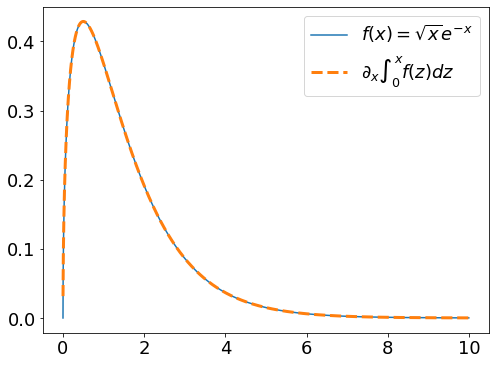

In [25]:
plt.figure(figsize=(8,6))
x = jnp.arange(0,10,0.001)
plt.plot(x,f5(x),label=r"$f(x)=\sqrt{x}e^{-x}$")
plt.plot(x,vmap(grad(intf5))(x), ls="--", lw=3, label="$\partial_x \int_0^x f(z)dz$")
plt.legend();

# Une methode plus efficace d'integration: Quadrature de Clenshaw Curtis

In [56]:
from typing import NamedTuple, Tuple

from jax import Array, jit, lax, vmap

# move pure function out of the class
def abs_weights(n: int):
  #assert n > 1
  points = -jnp.cos(jnp.linspace(0, jnp.pi, n))

  if n == 2:
    weights = jnp.array([1.0, 1.0])
    return points, weights

  n -= 1
  N = jnp.arange(1, n, 2)
  length = len(N)
  m = n - length
  v0 = jnp.concatenate([2.0 / N / (N - 2), jnp.array([1.0 / N[-1]]), jnp.zeros(m)])
  v2 = -v0[:-1] - v0[:0:-1]
  g0 = -jnp.ones(n)
  g0 = g0.at[length].add(n)
  g0 = g0.at[m].add(n)
  g = g0 / (n**2 - 1 + (n % 2))

  w = jnp.fft.ihfft(v2 + g)
  # assert max(w.imag) < 1.0e-15
  w = w.real

  if n % 2 == 1:
    weights = jnp.concatenate([w, w[::-1]])
  else:
    weights = jnp.concatenate([w, w[len(w) - 2::-1]])

  return points, weights

class ClenshawCurtisQuad(NamedTuple):  # NamedTuple is already a pytree
  order: int
  absc: Array
  absw: Array
  errw: Array

  @classmethod  # alternative constructor, doesn't get in the way of flatten/unflatten
  def init(cls, order: int):
    order = 2 * order + 1
    absc, absw, errw = cls.compute_weights(order)
    absc, absw = cls.rescale_weights(absc, absw)
    return cls(order=order, absc=absc, absw=absw, errw=errw)

  @staticmethod  # staticmethod to ensure pureity
  def compute_weights(order: int):
    x, wx = abs_weights(order)
    nsub = (order + 1) // 2
    _, wsub = abs_weights(nsub)
    errw = wx.at[::2].add(-wsub)
    return x, wx, errw

  @staticmethod
  def rescale_weights(
    absc: Array,
    absw: Array,
    *,
    interval_in: Tuple[float, float] = (-1, 1),
    interval_out: Tuple[float, float] = (0, 1),
  ):
    (in_min, in_max), (out_min, out_max) = interval_in, interval_out
    delta_in, delta_out = in_max - in_min, out_max - out_min
    absc = ((absc - in_min) * out_max - (absc - in_max) * out_min) / delta_in
    absw = delta_out / delta_in * absw
    return absc, absw

@partial(jit, static_argnums=(0,))
def quad_integral(f, a, b, quad: ClenshawCurtisQuad):
  a = jnp.atleast_1d(a)
  b = jnp.atleast_1d(b)
  d = b - a
  xi = a[jnp.newaxis, :] + jnp.einsum('i...,k...->ik...', quad.absc, d)
  xi = xi.squeeze()
  fi = f(xi)
  S = d * jnp.einsum('i...,i...', quad.absw, fi)
  return S.squeeze()  # d * jnp.einsum('i...,i...', quad.errw, fi)


## un peu de benchmarking: 1) warm-up pour la compilation, 2) block_until_ready()

avec la Famille de functions + # lots d'intervalles d'integration [a,a+1/2] a:0,0.1,0.2...

In [37]:
quad = ClenshawCurtisQuad.init(150)

In [47]:
res_sim = jax_simps(jax_funcN,ja,jb,N=2**15)


In [48]:
res_cc=quad_integral(jax_funcN,ja,jb,quad)


In [49]:
np.allclose(res_cc,res_sim,rtol=0.,atol=1e-6)  # atol=1e-7 => False

True

In [ ]:
#warm
#%time tmp=jax_simps(jax_funcN,jnp.array([0]),jnp.array([1]),N=4).block_until_ready()

In [50]:
# Too long .....%timeit  res_sim = jax_simps(jax_funcN,ja,jb,N=2**15).block_until_ready()

In [ ]:
#warm besoin si on veut voir le temps de comoilation XLA
#%time quad_integral(jax_funcN,jnp.array([0]),jnp.array([1]),quad).block_until_ready()


In [51]:
%timeit quad_integral(jax_funcN,ja,jb,quad).block_until_ready()


82.4 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Incrémental intégration

In [52]:
def incremental_int(fn,t, order=10):
    """Incremetal intergration using Clenshaw Curtis Quadrature

       Example::
           >>> f = lambda x: jnp.sqrt(x) * jnp.exp(-x) * jnp.sin(100.*x)
           >>> tinc = jnp.linspace(0.,1.,4096)
           >>> incremental_int(f5,tinc,150)

       It uses CC quad to compute int_t[i]^t[i+1] fn(x) dx

       Inputs:
           fn : function (vectorized of 1 variable)
           t : array
           order : order of the Clenshaw Curtis Quadrature
       Outputs:
           array of int_t[0]^t[i] fn(x) dx  i=0, len(t)-1

    """
    quad = ClenshawCurtisQuad.init(order)
    def integ(carry,t):
        y, t_prev = carry
        y = y + quad_integral(fn,t_prev,t,quad)
        return (y,t),y
    (yf, _), y = jax.lax.scan(integ, (0., jnp.array(t[0])), t)
    return y

In [80]:
quad=ClenshawCurtisQuad.init(150) 
tdef = jnp.linspace(0,10,5000)
res_cc_def = quad_integral(f5,0.0,tdef,quad)


In [82]:
tinc = jnp.linspace(0,10,5000)
res_cc_inc = incremental_int(f5,tinc)  # note order << 150

In [83]:
true_intf5 = lambda t: jnp.exp(jsc.special.gammaln(1.5))\
        *(1.-jsc.special.gammaincc(1.5,t))


In [84]:
t_val=jnp.linspace(0,10,5000)

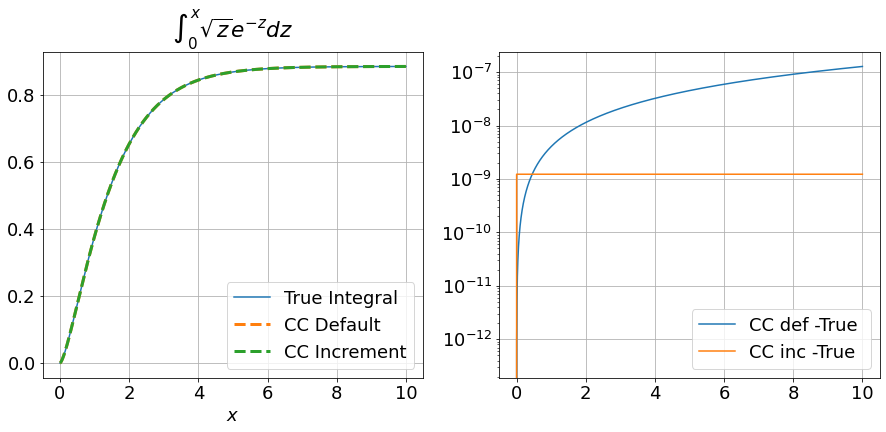

In [85]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(t_val, vmap(true_intf5)(t_val), label="True Integral")
ax[0].plot(t_val, jnp.interp(t_val,tdef,res_cc_def),lw=3,ls="--", label="CC Default")
ax[0].plot(t_val, jnp.interp(t_val,tinc,res_cc_inc),lw=3,ls="--", label="CC Increment")
ax[0].set_xlabel(r"$x$")
ax[0].legend()
ax[0].grid()
ax[0].set_title(r"$\int_0^x \sqrt{z} e^{-z} dz$");
#
ax[1].plot(t_val, jnp.abs(res_cc_def-vmap(true_intf5)(t_val)), label="CC def -True ")
ax[1].plot(t_val, jnp.abs(res_cc_inc-vmap(true_intf5)(t_val)), label="CC inc -True ")
ax[1].set_yscale("log")
ax[1].legend()
ax[1].grid()


# Un peu de Cosmo: qq etudes autour des distances...

On va créer une classe PyTree


In [86]:
from dataclasses import dataclass
from jax.tree_util import register_pytree_node_class

@dataclass(frozen=True)
class Constante:
    rh: float = 2997.92458  # h^{-1} Mpc
    H0: float = 100.0  # km/s/( h^{-1} Mpc)

const = Constante()


#The set of Python types that are considered internal PyTree nodes is extensible
@register_pytree_node_class
class Cosmology:
    def __init__(self, Omega_c, Omega_b, h, Omega_k, w0, wa):
        """
            Omega_c, float
              Cold dark matter density fraction.
            Omega_b, float
              Baryonic matter density fraction.
            h, float
              Hubble constant divided by 100 km/s/Mpc; unitless.
            Omega_k, float
              Curvature density fraction.
            w0, float
              First order term of dark energy equation
            wa, float
              Second order term of dark energy equation of state
        """
        # Store primary parameters
        self._Omega_c = Omega_c
        self._Omega_b = Omega_b
        self._h = h
        self._Omega_k = Omega_k
        self._w0 = w0
        self._wa = wa
    
        # Create a workspace where functions can store some precomputed
        # results
        self._workspace = {}

    def __str__(self):
        return (
              " h:"+ str(self.h)
            + " Omega_b:"+ str(self.Omega_b)
            + " Omega_c:"+ str(self.Omega_c)
            + " Omega_k:"+ str(self.Omega_k)
            + " w0:"+ str(self.w0)
            + " wa:"+ str(self.wa)
        )

    def __repr__(self):
        return self.__str__()

    # Operations for flattening/unflattening representation
    def tree_flatten(self):
        params = (
            self._Omega_c,
            self._Omega_b,
            self._h,
            self._Omega_k,
            self._w0,
            self._wa,
        )
        aux_data = None
        return (params, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        # Retrieve base parameters
        Omega_c, Omega_b, h, Omega_k, w0, wa = children

        return cls(
            Omega_c=Omega_c,
            Omega_b=Omega_b,
            h=h,
            Omega_k=Omega_k,
            w0=w0,
            wa=wa,
        )
    
    # Cosmological parameters, base and derived
    @property
    def Omega(self):
        return 1.0 - self._Omega_k

    @property
    def Omega_b(self):
        return self._Omega_b

    @property
    def Omega_c(self):
        return self._Omega_c

    @property
    def Omega_m(self):
        return self._Omega_b + self._Omega_c

    @property
    def Omega_de(self):
        return self.Omega - self.Omega_m

    @property
    def Omega_k(self):
        return self._Omega_k

    @property
    def k(self):
        return -jnp.sign(self._Omega_k).astype(jnp.int8)

    @property
    def sqrtk(self):
        return jnp.sqrt(jnp.abs(self._Omega_k))

    @property
    def h(self):
        return self._h

    @property
    def w0(self):
        return self._w0

    @property
    def wa(self):
        return self._wa


$$
\begin{align}
(H(a)/H0)^2 &= E^2(a) = a^{-3}\Omega_m + a^{-2}\Omega_K +\Omega_Lambda e^{f(a)} \\
f(a) &= -3(1+ω_0 + ω_a)\ln(a) + 3w_a(a-1) 
\end{align}
$$
Notez que si $\omega_0=-1$ et $ω_a=0$ (Lambda CDM) alors $f(a)=0$

$$
\chi(a) = R_H \int_a^1 \frac{da'}{a'^2E(a')}
$$

Transverse comoving distance
$$
f_k(a) = \begin{cases}
R_H \frac{1}{\sqrt{Ω_k}}\sinh(\sqrt{Ω_k}R_H \chi(a)) &  for\ Ω_k>0 \\
\chi(a) &for\ Ω_k=0 \\
R_H \frac{1}{\sqrt{Ω_k}}\sin(\sqrt{Ω_k}R_H \chi(a)) &  for\ Ω_k < 0
\end{cases}
$$
distance angulaire et de luminosité
$$
d_A(a) = a f_k(a), \qquad d_L(a) = f_k(a)/a 
$$


In [96]:
atab = jnp.logspace(-3, 0.0, 10)
atabbis = jnp.log(atab)
atab

DeviceArray([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
             0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ],            dtype=float64)

In [97]:
def z2a(z):
    """converts from redshift to scale factor"""
    return 1.0 / (1.0 + z)

def a2z(a):
    """converts from scale factor to  redshift"""
    return 1.0 / a - 1.0

def w(cosmo, a):
    """
    Linder 2003
     w(a) = w_0 + w_a (1 - a)
    """
    return cosmo.w0 + (1.0 - a) * cosmo.wa 

def f_de(cosmo, a):
    """
        f(a) = -3 (1 + w_0 + w_a) \ln(a) + 3 w_a (a - 1)
    """
    return -3.0 * (1.0 + cosmo.w0 + cosmo.wa) * jnp.log(a) + 3.0 * cosmo.wa * (a - 1.0)

def Esqr(cosmo, a):
    """
      E^2(a) = \Omega_m a^{-3} + \Omega_k a^{-2} + \Omega_{de} e^{f(a)} =H(a)^2/H0^2
    """
    return (
        cosmo.Omega_m * jnp.power(a, -3)
        + cosmo.Omega_k * jnp.power(a, -2)
        + cosmo.Omega_de * jnp.exp(f_de(cosmo, a))
    )

def H(cosmo, a):
    """
    H(a) = H0 * E(a)
    """
    return const.H0 * jnp.sqrt(Esqr(cosmo, a))

def dchioverda(cosmo, a):
    """
    \frac{d \chi}{da}(a) = \frac{R_H}{a^2 E(a)}
    """
    return const.rh / (a**2 * jnp.sqrt(Esqr(cosmo, a)))

def radial_comoving_distance(cosmo, a, log10_amin=-3, steps=256):
    """
    \chi(a) =  R_H \int_a^1 \frac{da^\prime}{{a^\prime}^2 E(a^\prime)}
    """
    # Check if distances have already been computed
    if not "background.radial_comoving_distance" in cosmo._workspace.keys():
        # Compute tabulated array
        atab = jnp.logspace(log10_amin, 0.0, steps)
        

        def dchioverdlna(x):
            xa = jnp.exp(x)
            return dchioverda(cosmo, xa) * xa

        
        chitab_cc_inc = incremental_int(dchioverdlna, jnp.log(atab), order=3)
        chitab_cc_inc = chitab_cc_inc[-1]-chitab_cc_inc
        
        cache = {"a": atab, "chi":chitab_cc_inc}
        cosmo._workspace["background.radial_comoving_distance"] = cache
    else:
        cache = cosmo._workspace["background.radial_comoving_distance"]

    #a = jnp.atleast_1d(a)
    # Return the results as an interpolation of the table
    return jnp.clip(jnp.interp(a, cache["a"], cache["chi"]), 0.0)

def transverse_comoving_distance(cosmo, a):
    r"""Transverse comoving distance in [Mpc/h] for a given scale factor.

    f_k : ndarray, or float if input scalar
        Transverse comoving distance corresponding to the specified
        scale factor.
    Notes
    -----
    The transverse comoving distance depends on the curvature of the
    universe and is related to the radial comoving distance through:
    .. math::
        f_k(a) = \left\lbrace
        \begin{matrix}
        R_H \frac{1}{\sqrt{\Omega_k}}\sinh(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for }\Omega_k > 0 \\
        \chi(a)&
            \mbox{for } \Omega_k = 0 \\
        R_H \frac{1}{\sqrt{\Omega_k}} \sin(\sqrt{|\Omega_k|}\chi(a)R_H)&
            \mbox{for } \Omega_k < 0
        \end{matrix}
        \right.
    """  
    index = cosmo.k + 1

    def open_universe(chi):
        return const.rh / cosmo.sqrtk * jnp.sinh(cosmo.sqrtk * chi / const.rh)

    def flat_universe(chi):
        return chi

    def close_universe(chi):
        return const.rh / cosmo.sqrtk * jnp.sin(cosmo.sqrtk * chi / const.rh)

    branches = (open_universe, flat_universe, close_universe)

    chi = radial_comoving_distance(cosmo, a)

    #def switch(index, branches, operand):
    #index = clamp(0, index, len(branches) - 1)
    #return branches[index](operand)

    return jax.lax.switch(cosmo.k + 1, branches, chi)

def angular_diameter_distance(cosmo, a):
    """Angular diameter distance in [Mpc/h] for a given scale factor.
        d_A(a) = a f_k(a)
    """
    return a * transverse_comoving_distance(cosmo, a)

def luminosity_distance(cosmo, a):
    """Angular diameter distance in [Mpc/h] for a given scale factor.
        d_L(a) = f_k(a) / a
    """
    return transverse_comoving_distance(cosmo, a)/a

In [98]:
# Cosmologie "Standard"
cosmo_jax = Cosmology(
    Omega_c=0.2545,
    Omega_b=0.0485,
    h=0.682,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0  
)

In [99]:
cosmo_jax.Omega_de   # 1 - Omega_k - cosmo_jax._Omega_m

0.6970000000000001

In [100]:
cosmo_jax.Omega_m,  cosmo_jax._Omega_b + cosmo_jax._Omega_c  # cosmo_jax._Omega_b + cosmo_jax._Omega_c

(0.303, 0.303)

In [101]:
cosmo_jax.Omega_de + cosmo_jax.Omega_m

1.0

In [102]:
z = jnp.logspace(-3, 3,100)
chi_z = radial_comoving_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
trans_com_z = transverse_comoving_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
ang_diam_z= angular_diameter_distance(cosmo_jax, z2a(z))/ cosmo_jax.h
lum_z = luminosity_distance(cosmo_jax, z2a(z)) / cosmo_jax.h



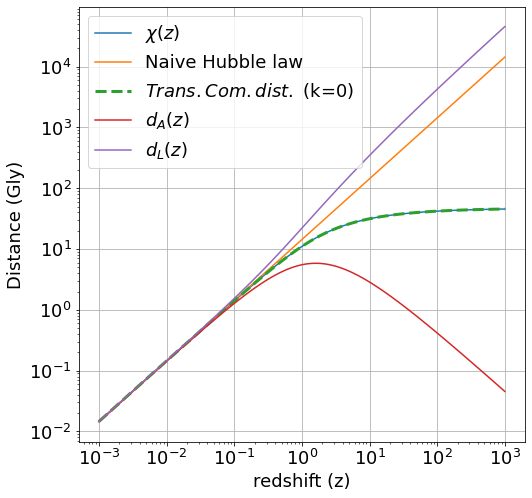

In [103]:
plt.figure(figsize=(8,8))
factMpc2Gly = 0.0032615 #Mpc -> Gly
plt.plot(z,factMpc2Gly * chi_z, label=r"$\chi(z)$")
plt.plot(z,factMpc2Gly * const.rh/cosmo_jax.h * z, label="Naive Hubble law")
plt.plot(z,factMpc2Gly * trans_com_z,ls="--",lw=3, label=rf"$Trans. Com. dist.$ (k={cosmo_jax.k})")
plt.plot(z,factMpc2Gly * ang_diam_z, label=r"$d_A(z)$")
plt.plot(z,factMpc2Gly * lum_z, label=r"$d_L(z)$")
plt.xlabel("redshift (z)")
plt.ylabel("Distance (Gly)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()

## gradient/vectorisation sur $\Omega_c$


In [110]:
omc=jnp.linspace(0.001,0.5,5) # series of values

In [104]:
def test(cosmo,z):
    return cosmo.Omega_c * z


le gradient est sur le 1er arguemnt de test (cosmo_jax dont on prend seulement la composante que Omega_c ou Omega_), et on vectorize ensuite sur le 2nd arguement ici le redshift 

In [105]:
vmap(grad(test), in_axes=(None,0))(cosmo_jax,jnp.array([0.01,0.1,1.0])).Omega_c

DeviceArray([0.01, 0.1 , 1.  ], dtype=float64, weak_type=True)

In [106]:
vmap(grad(test), in_axes=(None,0))(cosmo_jax,jnp.array([0.01,0.1,1.0])).Omega_b

DeviceArray([0., 0., 0.], dtype=float64, weak_type=True)

In [107]:
vlum = vmap(luminosity_distance, in_axes=(Cosmology(0, None,None,None,None,None), None))
vang_diam = vmap(angular_diameter_distance, in_axes=(Cosmology(0, None,None,None,None,None), None))


In [111]:
cosmo_cs = Cosmology(omc,cosmo_jax.Omega_b,cosmo_jax.h,cosmo_jax.Omega_k,cosmo_jax.w0,cosmo_jax.wa)


In [112]:
cosmo_cs.Omega_de[0]


DeviceArray(0.9505, dtype=float64)

In [113]:
data_lum=vlum(cosmo_cs,z2a(z))
data_lum /= cosmo_jax.h


In [114]:
data_ang_diam=vang_diam(cosmo_cs,z2a(z))
data_ang_diam /= cosmo_jax.h


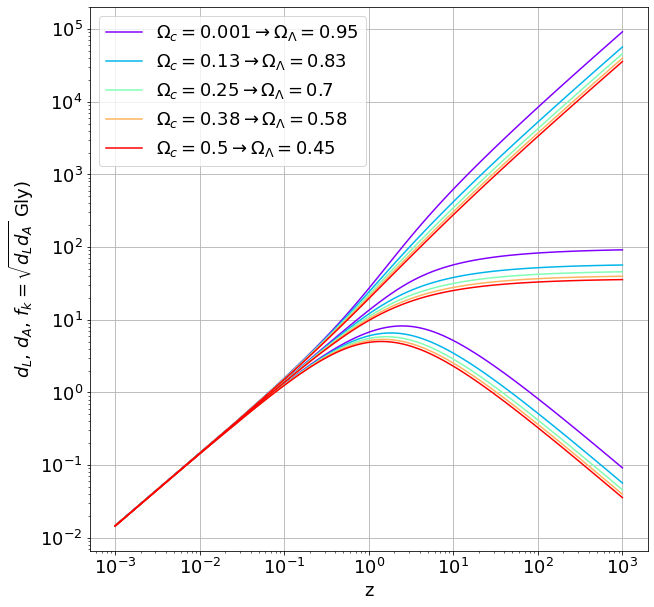

In [115]:
plt.figure(figsize=(10,10))
color = plt.cm.rainbow(np.linspace(0, 1, len(omc)))
for i,c in enumerate(omc):
    plt.plot(z, factMpc2Gly*data_lum[i,:], c=color[i],
             label=fr"$\Omega_c={c:.2}\rightarrow \Omega_{{\Lambda}}={cosmo_cs.Omega_de[i]:.2}$")
    plt.plot(z, factMpc2Gly*data_ang_diam[i,:], c=color[i])
    plt.plot(z, factMpc2Gly*np.sqrt(data_lum[i,:]*data_ang_diam[i,:]), c=color[i])
plt.legend()
plt.xlabel("z")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"$d_L$, $d_A$, $f_k=\sqrt{d_L d_A}$ Gly)")
plt.grid();


# Takeaway message:

-    la différentiation d'algorithmes complexes est possible s'ils sont écrits en JAX
-    des études complexes de dépendance vis-à-vis de paramètrs sont possibles assez simplement
-    usage pratique des PyTree user
-    jax.scipy implémente des fonctionalités de Scipy
-    jax.lax.fori_loop, jax.lax.scan, jax.lax.switch
- vectorizaton vmap, compilation jit
-    le benchmarking

